pip install --upgrade tensorflow keras

In [1]:
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import transformers as ppb
import torch
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision.io import read_image
#from tensorflow.keras.applications.resnet import ResNet50
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import os
from pathlib import Path
from tqdm import tqdm
import pickle
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch.nn as nn
import nltk
import urllib.request

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers  import GlobalAveragePooling2D,Dense
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
#from tensorflow.keras.optimizers import Adam

C:\Users\karpa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karpa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\karpa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karpa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [3]:
path='.'

In [4]:
train_data_info = pd.read_csv(path+'/train_dataset.csv')

In [5]:
train_data_info.head(5)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [6]:
test_data_info = pd.read_csv(path+'/test_queries.csv', sep='|')

In [7]:
column_names = ['name_img', 'id_discr', 'count', 'count_true', 'count_false'] 

In [8]:
CrowdAnnotations = pd.read_csv(path+'/CrowdAnnotations.tsv', sep='\t', names=column_names)

In [9]:
column_names = ['name_img', 'id_discr', 'exp_1', 'exp_2', 'exp_3'] 

In [10]:
ExpertAnnotations = pd.read_csv(path+'/ExpertAnnotations.tsv', sep='\t', names=column_names)

Рассмотрим более детально оценки экспертов в ExpertAnnotations и найдет по каждой фото среднее значение

In [11]:
CrowdAnnotations.head(5)

,name_img,id_discr,count,count_true,count_false
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [12]:
ExpertAnnotations['avg_exp']=(ExpertAnnotations['exp_1']+ExpertAnnotations['exp_2']+ExpertAnnotations['exp_3'])/3

In [13]:
ExpertAnnotations.head(5)

,name_img,id_discr,exp_1,exp_2,exp_3,avg_exp
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.333333
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.333333
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,1.666667
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.333333


Рассмотрим более детально оценки экспертов в CrowdAnnotations и найдем по каждой фото среднее значение

In [14]:
CrowdAnnotations.head(5)

,name_img,id_discr,count,count_true,count_false
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


ОБъеденим оценки в итоговый dataset

In [15]:
 megre_df=pd.merge(ExpertAnnotations, CrowdAnnotations, on=['name_img','id_discr'], how='outer')

In [16]:
 megre_df.head(5)

,name_img,id_discr,exp_1,exp_2,exp_3,avg_exp,count,count_true,count_false
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,NaN,NaN,NaN,1.0,3.0,0.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,NaN,NaN,NaN,NaN,0.0,0.0,3.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,NaN,NaN,NaN,NaN,0.0,0.0,3.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,NaN,NaN,NaN,NaN,0.0,0.0,3.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,NaN,NaN,NaN,NaN,0.0,0.0,3.0


In [17]:
  ExpertAnnotations[ExpertAnnotations['name_img']=='1056338697_4f7d7ce270.jpg']

,name_img,id_discr,exp_1,exp_2,exp_3,avg_exp
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.333333
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.333333
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,1.666667
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.333333
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1,1.000000
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1,1.000000
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2,1.333333


In [18]:
CrowdAnnotations[CrowdAnnotations['name_img']=='1056338697_4f7d7ce270.jpg']

,name_img,id_discr,count,count_true,count_false
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3


In [19]:
megre_df[megre_df['name_img']=='1056338697_4f7d7ce270.jpg']

,name_img,id_discr,exp_1,exp_2,exp_3,avg_exp,count,count_true,count_false
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,NaN,NaN,NaN,1.000000,3.0,0.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,NaN,NaN,NaN,NaN,0.333333,1.0,2.0
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,NaN,NaN,NaN,NaN,0.000000,0.0,3.0


In [20]:
megre_df=megre_df.fillna(0)

In [21]:
 megre_df['itog']=megre_df['avg_exp']*0.6+megre_df['count']*0.4

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [22]:
bad_words=['girl', 'boy', 'children', 'child','baby']

In [23]:
train_data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [24]:
for i in bad_words: 
    train_data_info=train_data_info[train_data_info['query_text'].apply(lambda x: i in x)==False]

In [25]:
train_data_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4408 entries, 22 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4408 non-null   object
 1   query_id    4408 non-null   object
 2   query_text  4408 non-null   object
dtypes: object(3)
memory usage: 137.8+ KB


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:

# Step 1: Initialize the model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.to(device)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms(antialias=True)

# Step 3: Create the feature extractor with the required nodes
return_nodes = {'flatten': 'flatten'}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

In [28]:
def get_image_vector(image_path):

    # Step 4: Load the image(s) and apply inference preprocessing transforms
    image = read_image(image_path).unsqueeze(0)
    model_input = preprocess(image).to(device)

    with torch.no_grad():
        # Step 5: Extract the features
        features = feature_extractor(model_input)
        flatten_fts = features["flatten"].squeeze()

        # тут специально переводим на CPU
        return flatten_fts.to('cpu').detach().numpy()

Протестируем размер вектора, который получается после обработки изображения

In [29]:
# словарь для хранения результата обработки
image_vectors = {}
def images2vector(folder):
    count = 0

    for p in Path(folder).glob('*.jpg'):
        count+=1

    with tqdm(total=count) as pbar:
        for p in Path(folder).glob('*.jpg'):
            image_vectors[p.name] = get_image_vector(folder + f'/{p.name}')

            pbar.update(1)


In [30]:
TMP='.'

In [31]:
# используем кэш
if os.path.exists(TMP + '/image_vectors.pickle'):
    image_vectors = pickle.load(open(TMP + '/image_vectors.pickle', 'rb'))
else:
    images2vector(path+'/train_images/' )
    pickle.dump(image_vectors, file = open(TMP + '/image_vectors.pickle', 'wb'))
# проверим сформированный объект
img1 = list(image_vectors.keys())[0]
image_vectors[img1].shape

print(f'''Векторизация изображения на заранее обученной модели resnet18 позволило сделать вектор длинной {image_vectors[img1].shape[0]}
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.''')

Векторизация изображения на заранее обученной модели resnet18 позволило сделать вектор длинной 512
Уменьшение вектора позволит сэкономить ресурсы и вычислительное время при обучении.


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [32]:
# обучать будем на специальной модели
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [33]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [34]:
def voctoring_text(sent):
    #Tokenize sentences
    encoded_input = tokenizer(sent, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

    #Compute token embeddings
    with torch.no_grad():
        #print(model)
        model_output = model(**encoded_input)
        #print('end')
        print(model_output)
        #print('end_1')

    #Perform pooling. In this case, mean pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    #print('end_2')
    
    pbar_2.update(1)
    ar = sentence_embeddings[0].to('cpu').detach().numpy()
    return ar

In [35]:
if os.path.exists(TMP + '/train_dataset.pickle'):
    train_data_info = pickle.load(open(TMP + '/train_dataset.pickle', 'rb'))
else:
    with tqdm(total=train_data_info.shape[0]) as pbar_2:
        train_data_info['text2vec'] = train_data_info['query_text'].apply(lambda x: voctoring_text(x))

    pickle.dump(train_data_info, file = open(TMP + '/train_dataset.pickle', 'wb'))

Проверим результат обработки текстовых данных

In [36]:
train_data_info.head()

,index,image,query_id,query_text,text2vec
0,22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024..."
1,23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024..."
2,24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024..."
3,25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024..."
4,26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024..."


In [37]:

print(f'После векторизации текста был создан Tensor размером {train_data_info.iloc[0]["text2vec"].shape}')

После векторизации текста был создан Tensor размером (768,)


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [38]:
def join_vectors(row):
    img = row['image']
    return image_vectors[img]

In [39]:
megre_df.head(5)

,name_img,id_discr,exp_1,exp_2,exp_3,avg_exp,count,count_true,count_false,itog
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.4
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [40]:
megre_df=megre_df.drop(['exp_1','exp_2','exp_3','count_true','count_false'], axis=1)

In [41]:
def extract_image(id_rec):
    image = id_rec['name_img']
    rez=image_vectors[image]
    return rez

In [42]:
megre_df['emmb_vec'] = megre_df.apply(extract_image, axis=1)

In [43]:
megre_df=megre_df.rename(columns={ 'name_img':'image','id_discr': 'query_id'})

In [44]:
megre_df=megre_df.set_index(['image','query_id'])

In [45]:
train_data_info=train_data_info.set_index(['image','query_id'])

In [46]:
merged_df=train_data_info.merge(megre_df, how='left', left_index=True, right_index=True)

In [47]:
def union_vectors(id_rec):
    rez=np.concatenate((id_rec['emmb_vec'], id_rec['text2vec']))
    return rez

In [48]:
merged_df['vec'] = merged_df.apply(union_vectors, axis=1)

In [49]:
print(f'Длина итогового вектора равна {merged_df.iloc[0]["text2vec"].shape[0]} + {merged_df.iloc[0]["vec"].shape[0]} = {len(merged_df.iloc[0]["vec"])}')

Длина итогового вектора равна 768 + 1280 = 1280


In [50]:
print(f'Вывод: после объединения двух векторов мы получаем третьи вектор длиной {len(merged_df.iloc[0]["vec"])}, который содержит конкатинированные признаки для дальнейшего обучения.')

Вывод: после объединения двух векторов мы получаем третьи вектор длиной 1280, который содержит конкатинированные признаки для дальнейшего обучения.


In [51]:
train_df=merged_df.drop(columns=['index'],axis=1)
train_df=train_df.reset_index()


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [52]:
train_df.head(5)

,image,query_id,query_text,text2vec,avg_exp,count,itog,emmb_vec,vec
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024...",1.333333,0.0,0.8,"[0.6645436, 3.0099623, 2.894568, 0.9445691, 0....","[0.6645436, 3.0099623, 2.894568, 0.9445691, 0...."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024...",1.666667,0.0,1.0,"[0.27318442, 2.4646223, 1.6143514, 1.242461, 1...","[0.27318442, 2.4646223, 1.6143514, 1.242461, 1..."
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024...",2.000000,0.0,1.2,"[0.9738347, 3.8057518, 1.2916154, 0.8006932, 0...","[0.9738347, 3.8057518, 1.2916154, 0.8006932, 0..."
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024...",1.666667,0.0,1.0,"[1.5541993, 1.0708152, 0.17263107, 0.2889722, ...","[1.5541993, 1.0708152, 0.17263107, 0.2889722, ..."
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.15153736, -0.09737311, -0.015055684, -0.024...",1.333333,0.0,0.8,"[0.33821768, 3.8320777, 1.1654173, 0.51477635,...","[0.33821768, 3.8320777, 1.1654173, 0.51477635,..."


Разделим DATA_SET на train и test

In [53]:
RANDOM_STATE=42

In [54]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=train_df.drop(columns=['itog']), y=train_df['itog'], groups=train_df['image']))
train_df, test_df = train_df.loc[train_indices], train_df.loc[test_indices]

In [55]:
x_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))
x_test = torch.FloatTensor(list(test_df.loc[:, 'vec'].values))

C:\Users\karpa\AppData\Local\Temp\ipykernel_10620\2156091792.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_train = torch.FloatTensor(list(train_df.loc[:, 'vec'].values))


In [56]:
y_train = torch.FloatTensor(train_df['itog'].values).reshape(-1, 1)
y_test = torch.FloatTensor(test_df['itog'].values).reshape(-1, 1)

произведем масштабирование

In [57]:
scaler = StandardScaler()

In [58]:
scaler.fit(x_train)

StandardScaler()

In [59]:
x_train = scaler.transform(x_train)

In [60]:
x_test = scaler.transform(x_test)

В качестве одной из моделей выберем LinearRegression

В качесве метирики выберем RMSE, так как у нас задача регрессии

In [61]:
model_lreg = LinearRegression()


In [62]:
model_lreg.fit(x_train, y_train)

LinearRegression()

In [63]:
pred = model_lreg.predict(x_test)

In [64]:
rmse_lr = mean_squared_error(y_test, pred) ** 0.5

In [65]:
print(f'RMSE для LinearRegression равно', round(rmse_lr, 3))

RMSE для LinearRegression равно 0.847


Полносвязные сети 

In [66]:
# создание датасета
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

создадим загрузчик данных

In [67]:
train_ds = CustomDataset(x_train, y_train)

In [68]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [69]:
test_ds = CustomDataset(x_test, y_test)

In [70]:
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [71]:
# проверим работу
train_features, train_labels = next(iter(train_dl))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1280])
Labels batch shape: torch.Size([32, 1])


Создадим собственную сеть с 7 слоями

In [72]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.L1 = nn.Linear(1280, 10240)
        self.L2 = nn.Linear(10240, 4096)
        self.L3 = nn.Linear(4096, 2048)
        self.L4 = nn.Linear(2048, 512)
        self.L5 = nn.Linear(512, 128)
        self.L6 = nn.Linear(128, 32)
        self.L7 = nn.Linear(32, 1)
        self.double()

        self.dp = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.L1(x)
        #x = self.relu(x)
        
        x = self.L2(x)
        x = self.relu(x)
        
        x = self.L3(x)
        x = self.relu(x)
        
        x = self.L4(x)
        x = self.relu(x)
        
        x = self.L5(x)
        x = self.relu(x)

        x = self.L6(x)
        x = self.relu(x)
        
        x = self.L7(x)

        return x

In [73]:
models = Net()
models.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(models.parameters(), lr=5e-6)

epochs = 10

min_valid_loss = np.inf

In [74]:
for e in range(epochs):
    train_loss = 0.0
    models.train()     # Optional when not using Model Specific layer
    for data, labels in train_dl:
        data, labels = data.to(device), labels.to(device)
        labels=labels.to(torch.double)
        #print(data.dtype)
        #print(labels.dtype)
        optimizer.zero_grad()
        target = models(data)
        #print('ff')
        loss = torch.sqrt(criterion(target,labels))
        loss=loss.to(torch.double)
        #print(loss.dtype)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    valid_loss = 0.0
    models.eval()     # Optional when not using Model Specific layer

    for data, labels in test_dl:
        data, labels = data.to(device), labels.to(device)
        labels=labels.to(torch.double)
        target = models(data)
        
        loss = torch.sqrt(criterion(target, labels))
        valid_loss += loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dl)} \t\t Validation Loss: {valid_loss / len(test_dl)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(models.state_dict(), TMP + '/saved_model.pth')

Epoch 1 		 Training Loss: 40.29740544277633 		 Validation Loss: 34.92858514160156
Validation Loss Decreased(inf--->1467.000576) 	 Saving The Model
Epoch 2 		 Training Loss: 22.397706171703366 		 Validation Loss: 16.143839466435036
Validation Loss Decreased(1467.000576--->678.041258) 	 Saving The Model
Epoch 3 		 Training Loss: 15.226466147341384 		 Validation Loss: 15.303750897941427
Validation Loss Decreased(678.041258--->642.757538) 	 Saving The Model
Epoch 4 		 Training Loss: 14.282758524239457 		 Validation Loss: 15.107129083998451
Validation Loss Decreased(642.757538--->634.499422) 	 Saving The Model
Epoch 5 		 Training Loss: 13.81476397942682 		 Validation Loss: 15.066795724277448
Validation Loss Decreased(634.499422--->632.805420) 	 Saving The Model
Epoch 6 		 Training Loss: 13.323471547912744 		 Validation Loss: 15.046668714013219
Validation Loss Decreased(632.805420--->631.960086) 	 Saving The Model
Epoch 7 		 Training Loss: 12.941030424356398 		 Validation Loss: 15.0737539038

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [75]:
def find_stop_word(in_text):
  
    in_text = in_text.lower()
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(in_text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

    for w in bad_words:
        word_len = len(w.split())

        if word_len > 1:
            if w in in_text:
                return True
        elif word_len == 1:
            if w in in_text.split():
                return True

    return False


Загрузка модели

In [76]:
# загрузим модель
models = Net()
models.to(device)

models.load_state_dict(torch.load(TMP + '/saved_model.pth'))
models.eval()

Net(
  (L1): Linear(in_features=1280, out_features=10240, bias=True)
  (L2): Linear(in_features=10240, out_features=4096, bias=True)
  (L3): Linear(in_features=4096, out_features=2048, bias=True)
  (L4): Linear(in_features=2048, out_features=512, bias=True)
  (L5): Linear(in_features=512, out_features=128, bias=True)
  (L6): Linear(in_features=128, out_features=32, bias=True)
  (L7): Linear(in_features=32, out_features=1, bias=True)
  (dp): Dropout(p=0.5, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
)

Загрузка списка тестовых изображений

In [77]:
test_images_info = pd.read_csv(path + '/test_images.csv')
test_images_info.info()
test_images_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [78]:
test_data_info

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
...,...,...,...,...
495,495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg
496,496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg
497,497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg


Загрузим изображения

In [79]:
image_vectors = {}

# воспользуемся ранее созданным методом
images2vector(path + '/test_images')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.37it/s]


Тестирование модели

Загрузим изображение

urllib.request.urlretrieve('https://downloadscdn5.freepik.com/download_vector/jpg/0/23/22/22204/22204207_6585686.jpg?token=exp=1761842875~hmac=db164bbaf9831cdc863c98d18b3ac03a&filename=22204207_6585686.jpg', './Access-Denied-image.jpg')

In [80]:
def find_image(in_text):
   
    if find_stop_word(in_text):
        # Выводим сообщение связанное с юридическими ограничениями
        error_m='./Access-Denied-image.jpg', f'{in_text}\nThis image is unavailable in your country in compliance with local laws', None
        return error_m

    vec = voctoring_text_2(in_text)
    #print('end_vectorinc')

    # создадим данные для модели
    data = []
    images = []

    for key in image_vectors.keys():
        images.append(key)

        img = image_vectors[key]
        data.append(np.concatenate(( img,vec)))
        
    
    with torch.no_grad():
        data=scaler.transform(data)
        data=torch.Tensor(data).to(torch.double)
        pred = models(data.to(device)).to('cpu')
        # получаем индекс записи, которая больше всего подходит под описание
        idx = pred.numpy().argmax(axis=0)[0]

    return f'{path + '/test_images'}/{images[idx]}', in_text, pred[idx].numpy()[0]

In [81]:
def image_show(images, titles=None, nums=None):
    """
    Функция для просмотра изображения

    Параметры:
    ----------
    images: string[] - массив путей к изображениям
    titles: string[] - заголовоки
    nums: float[] - числовые показатели
    """
    fig = plt.figure(figsize=(10, len(images) * 3))

    for i in range(len(images)):
        fig.add_subplot(len(images), 1, i + 1)
        img = Image.open(images[i])
        if titles != None:
            if nums != None:
                if nums[i] == None:
                    plt.title(f'\n{titles[i]}', fontsize = 10)
                else:
                    plt.title(f'\n{str(nums[i])}\n{titles[i]}', fontsize = 10)
            else:
                plt.title(f'\n{titles[i]}', fontsize = 10)
        plt.axis('off')
        plt.imshow(img)

    plt.show()

In [82]:
test_images_info.head(5)

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [83]:
# получаем 10 случайных примеров из тестового dataset'а
queries = list(test_data_info.sample(30)['query_text'])

In [84]:
def voctoring_text_2(sent):
    #Tokenize sentences
    encoded_input = tokenizer(sent, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

    #Compute token embeddings
    with torch.no_grad():
        #print(model)
        model_output = model(**encoded_input)
        #print('end')
        #print(model_output)
        #print('end_1')

    #Perform pooling. In this case, mean pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    #print('end_2')
    
    #pbar_2.update(1)
    ar = sentence_embeddings[0].to('cpu').detach().numpy()
    return ar

In [85]:
images = []
labels = []
scores = []

for i in range(len(queries)):

    image_path, title, score = find_image(queries[i])

    images.append(image_path)
    if score == None:
        scores.append(None)
    else:
        scores.append(round(score, 3))
    labels.append(title)

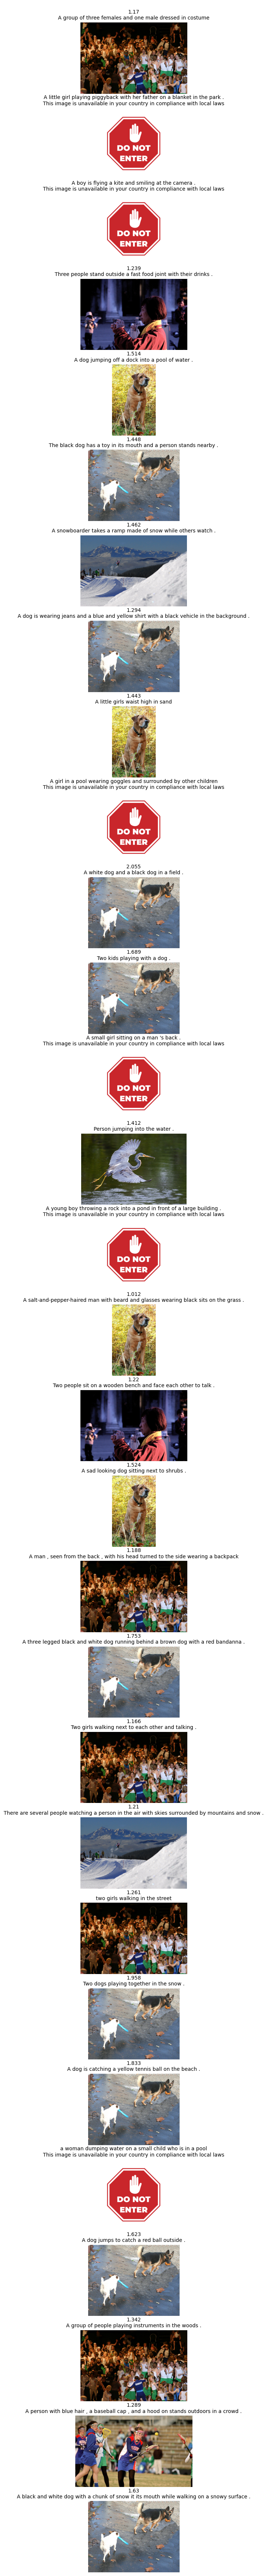

In [86]:
image_show(images, labels, scores)

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска

Наилучшее качество показывает модель на основе полносвзанной нейронной сети. 
Для улучшения качества модели возможно потребуется больше количество данных либо заниматься усовершенствованием модели.
Так же можно повысить качество модели в части юридических ограничений за счет внедрения модели для этого, так как необходимо оценивать контест. 